<a href="https://colab.research.google.com/github/Dias-lezdo/ai-learning-1/blob/main/ai_task-initial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.5).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


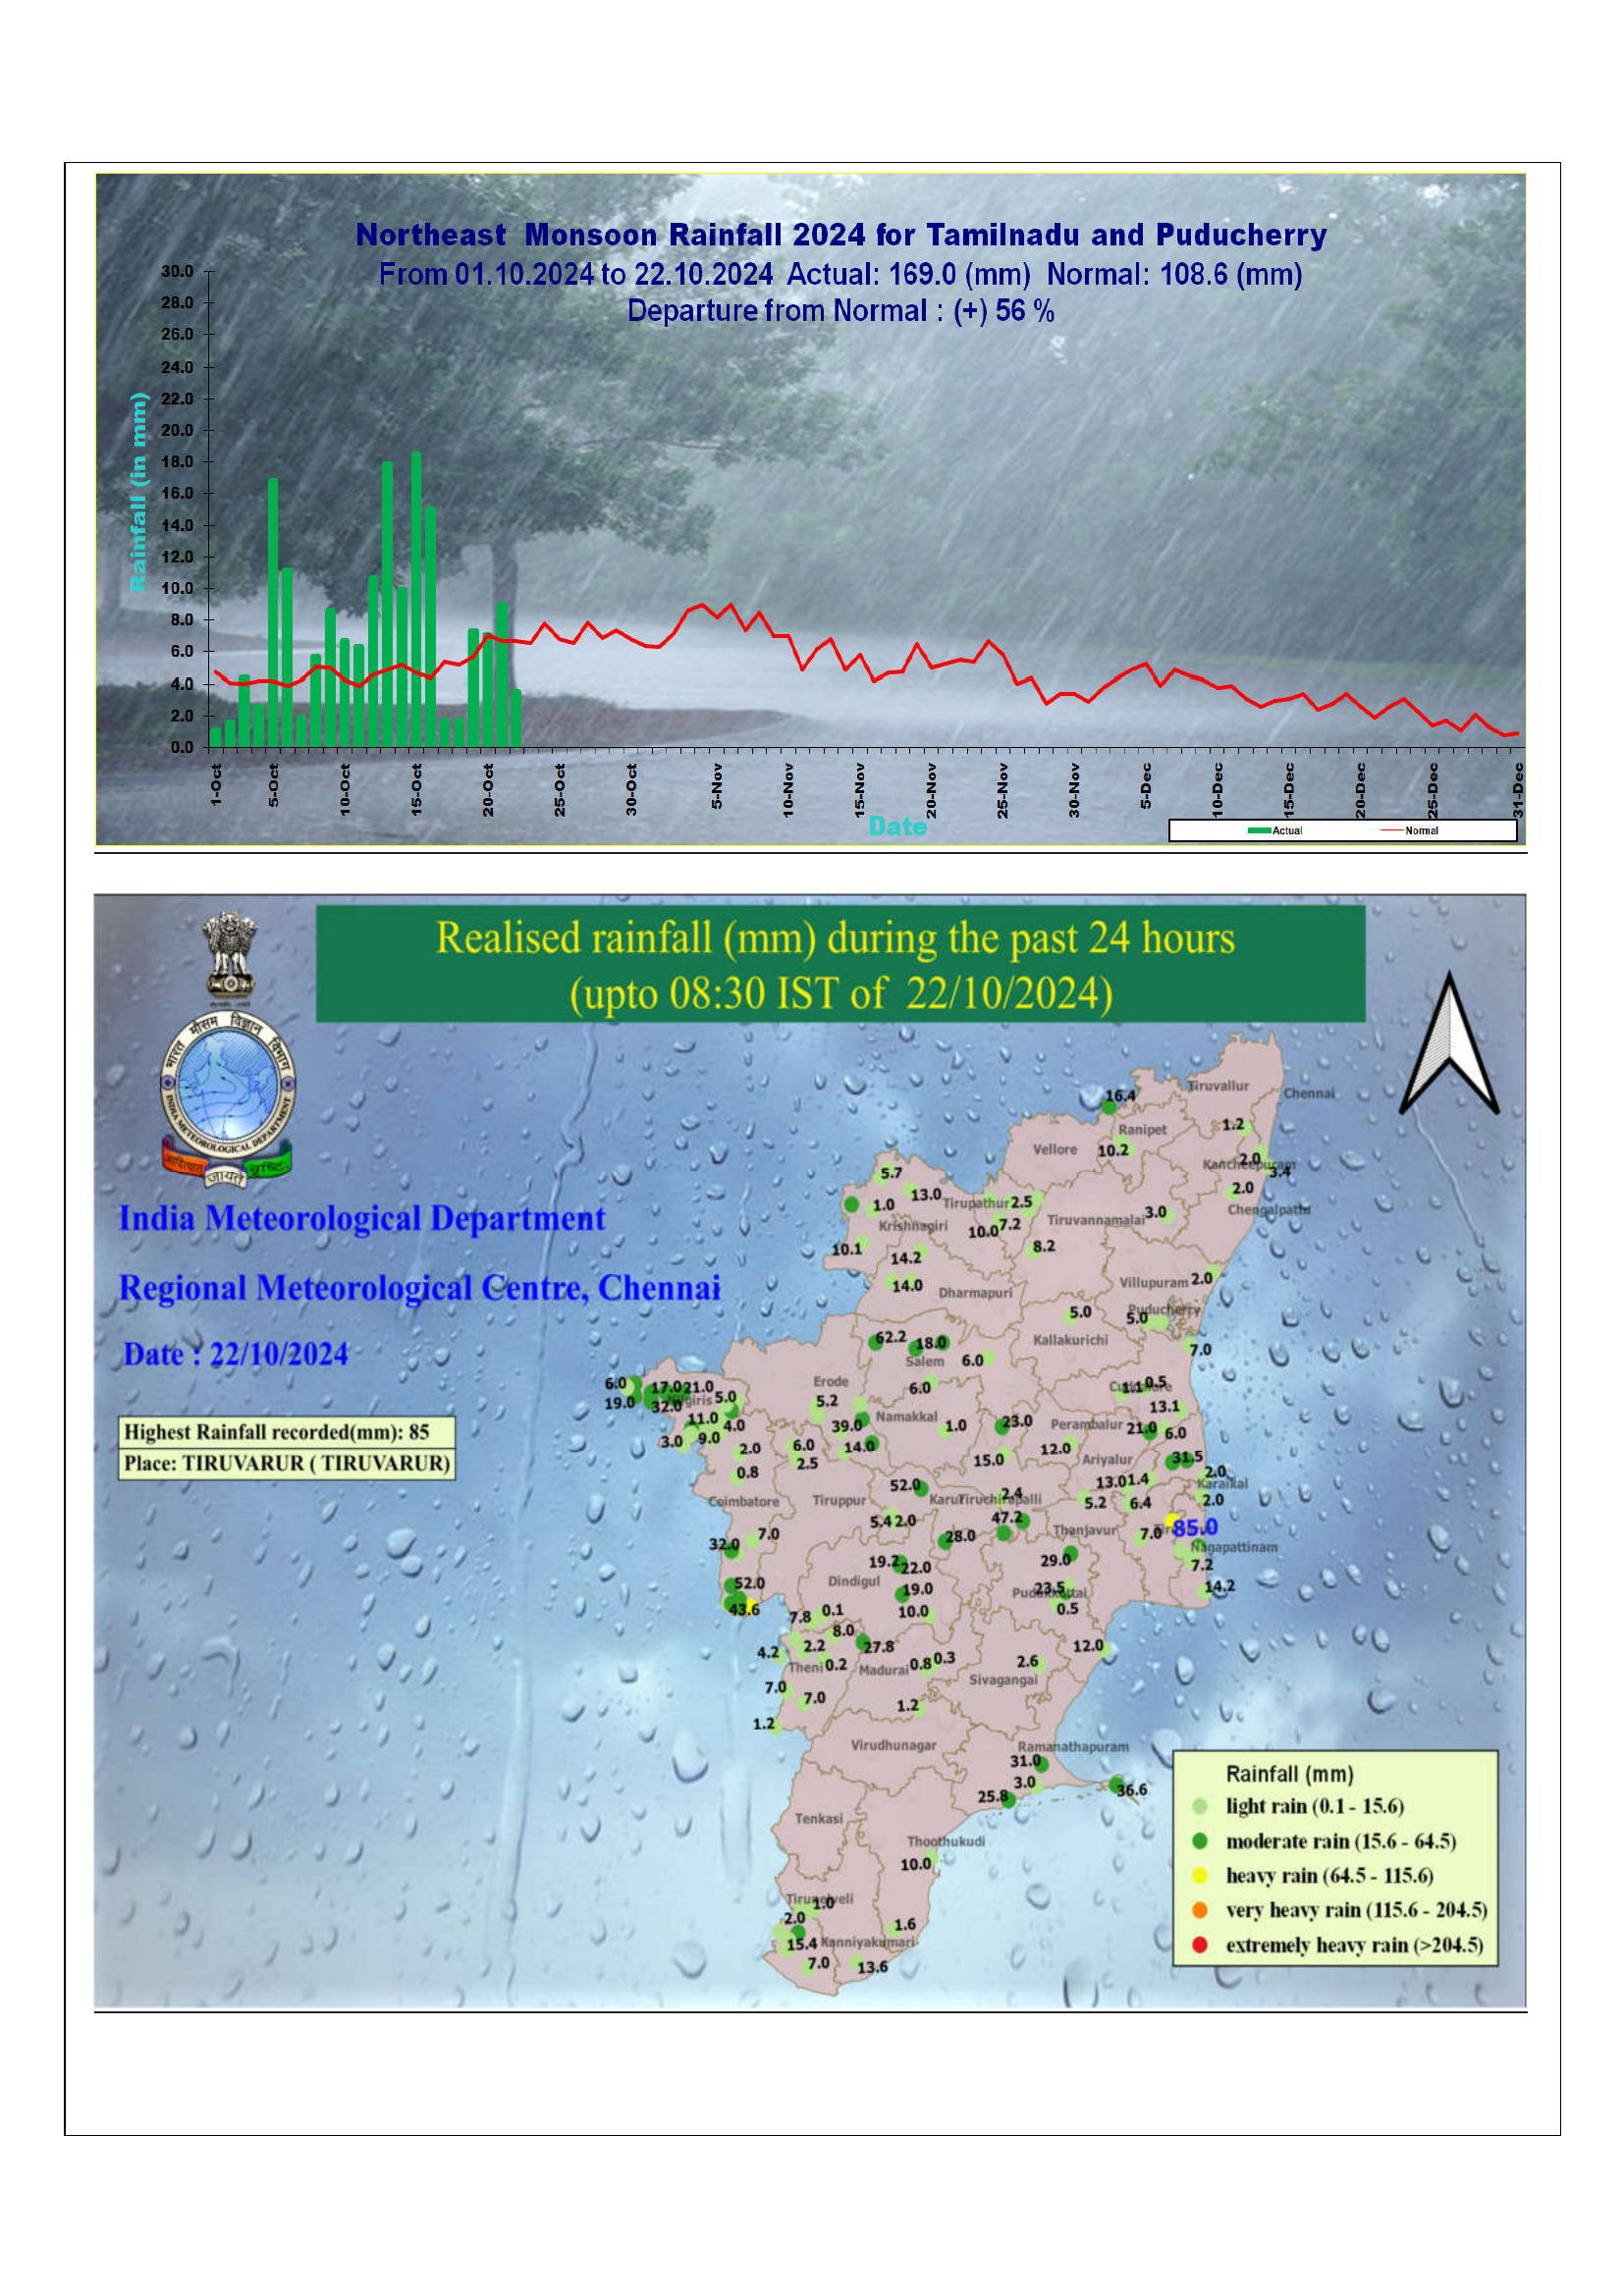

Original device: cpu
Using device: cpu
Verbosity is set to 1 (active). Pass verbose=0 to make quieter.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

AttributeError: 'RAGMultiModalModel' object has no attribute 'to'

In [18]:
# 1. Install Necessary Packages
!pip install --upgrade byaldi
!sudo apt-get install -y poppler-utils
!pip install -q pdf2image git+https://github.com/huggingface/transformers.git qwen-vl-utils flash-attn

# 2. Import Libraries and Authenticate
from huggingface_hub import notebook_login
notebook_login()

# 3. Convert PDF to Images
from pdf2image import convert_from_path

pdf_path = "/content/daily_weather_report.pdf"
images = convert_from_path(pdf_path)
display(images[5])  # Display the 6th page as a check

# 4. Initialize and Index with RAGMultiModalModel
from byaldi import RAGMultiModalModel
import torch

# Determine the device and force to CPU if necessary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Original device: {device}")

# Force to CPU to avoid BFloat16 issues on systems without proper support
device = torch.device("cpu")
print(f"Using device: {device}")

# Load the RAG model and move to the appropriate device (CPU in this case)
RAG = RAGMultiModalModel.from_pretrained("vidore/colpali")
RAG = RAG.to(device) # Make sure the model is on the CPU

# Index the PDF document, passing the device
RAG.index(
    input_path=pdf_path,
    index_name="image_index",
    store_collection_with_index=False,
    overwrite=True,
    device=device  # Pass the device to the index method
)

# 5. Perform a Text Query
text_query = "How much did the world temperature change so far?"
results = RAG.search(text_query, k=1)
print(results)

# 6. Load Qwen2-VL Model for Conditional Generation
from transformers import Qwen2VLForConditionalGeneration, AutoProcessor
from qwen_vl_utils import process_vision_info

# Load the Qwen2-VL model with appropriate dtype and move to device
model = Qwen2VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2-VL-2B-Instruct",
    trust_remote_code=True,
    torch_dtype=torch.float16  # Adjust if necessary
).to(device).eval()

# Load the processor
processor = AutoProcessor.from_pretrained(
    "Qwen/Qwen2-VL-2B-Instruct",
    trust_remote_code=True
)

# 7. Prepare the Input for the Model
if "page_num" in results[0]:
    image_index = results[0]["page_num"] - 1
else:
    raise ValueError("The search results do not contain 'page_num'.")

if image_index < 0 or image_index >= len(images):
    raise IndexError("Image index out of range.")

messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": images[image_index],
            },
            {
                "type": "text",
                "text": text_query
            },
        ],
    }
]

# 8. Process the Input and Generate a Response
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)

image_inputs, video_inputs = process_vision_info(messages)

inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)

inputs = {k: v.to(device) for k, v in inputs.items() if isinstance(v, torch.Tensor)}
if device.type == "cuda":
    inputs = {k: v.half() if v.dtype == torch.float32 else v for k, v in inputs.items()}

with torch.no_grad():
    generated_ids = model.generate(**inputs, max_new_tokens=50)

generated_ids_trimmed = [
    out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs["input_ids"], generated_ids)
]

output_text = processor.batch_decode(
    generated_ids_trimmed,
    skip_special_tokens=True,
    clean_up_tokenization_spaces=False
)

print(output_text)
